*TO-DO*:

- develop a code to make real-time predictions
- develop a function to compare 2 models with different prediction dimensions
- train another model with lstm-5-5
- compare the loss of lstm-5-5 & lstm-5-1 with the next 5 predictions

# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import json
import pygame
import time

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%matplotlib inline
sns.set_style("darkgrid")

%load_ext tensorboard

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from pandas import concat
from tensorflow import keras

In [4]:
from constants import *
import functions as f

# Preparing the Data

## Getting the values

In [5]:
file = open('data.json')
json_data = json.load(file)

json_lstm = json_data['models']['lstm']

In [6]:
df_hotel = f.getData(json_data['datasets']['seq_hotel'])
df_eth = f.getData(json_data['datasets']['seq_eth'])

# df_hotel = df_hotel.drop(['v_x', 'v_y'], axis = 1)
# df_eth = df_eth.drop(['v_x', 'v_y'], axis = 1)

# As we are merging, values have to added to 'frame_number' 'pedestrian_ID' to differentiate
df_eth = df_eth.apply(lambda x: x+1000 if x.name=='pedestrian_ID' else x)
df_eth = df_eth.apply(lambda x: x+2000 if x.name=='frame_number' else x)

df = pd.concat([df_hotel, df_eth])
df = df.reset_index()

## Grouping by Pedestrian

In [24]:
grp_df = df.groupby('pedestrian_ID')
for name, group in grp_df:
    print(group)
    break
    

    index  frame_number  pedestrian_ID     pos_x     pos_y       v_x       v_y
0       0             0              1  1.398378 -5.743303 -0.327083 -1.680286
10     10             1              1  1.267545 -6.415418 -0.327083 -1.680286


### Removing the pedestrians with steps less than the threshold

73
750


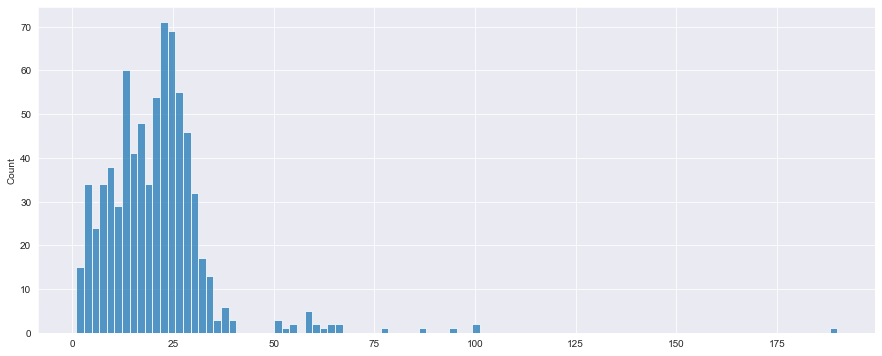

In [8]:
length = []
for name, group in grp_df:
    length.append(len(group))

plt.figure(figsize=(15, 6))
sns.histplot(length, bins = 100)

newL = [x for x in length if x <= json_lstm['window_size'] + json_lstm['no_of_forecasts']]
print(len(newL))
print(len(length))

In [9]:
df_ped = df.copy()
for name, group in grp_df:
    if len(group) <= json_lstm['window_size'] + json_lstm['no_of_forecasts']:
        df_ped = df_ped.drop(grp_df.get_group(name).index)
grp_reduced = df_ped.groupby('pedestrian_ID')

df_ped.to_csv(f"datasets/csvs/combined.csv", index=False)

## Converting the data to supervised

In [11]:
size_of_prediction = json_lstm["size_of_prediction"]

df_converted = pd.DataFrame()
for name, group in grp_reduced:
    pos_cols = group.iloc[:,-size_of_prediction:]               # Number of last columns
    pos_cols_converted = f.series_to_supervised(
        pos_cols, 
        json_lstm['window_size'],
        json_lstm['no_of_forecasts']
    )
    df_converted = pd.concat([df_converted, pos_cols_converted])
    
df_converted = df_converted.dropna()
df_converted.to_csv(f"datasets/csvs/lstms/seq-{json_lstm['window_size']}-{json_lstm['no_of_forecasts']}.csv", index=False)

# Models

In [12]:
X = df_converted.iloc[:,:json_lstm['window_size']*size_of_prediction].values
y = df_converted.iloc[:,json_lstm['window_size']*size_of_prediction:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8246, 1, 20) (8246, 4) (3534, 1, 20) (3534, 4)


In [13]:
# Defining the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(json_lstm['no_of_forecasts']*size_of_prediction)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             21760     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 34,308
Trainable params: 34,308
Non-trainable params: 0
_________________________________________________________________


In [14]:
epochs = 500
batch_size = 16

# Complie the Model
model.compile(loss='mae', optimizer='adam', metrics='acc')

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the Model
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    shuffle=False,
    callbacks=[tensorboard_callback]
    )

Epoch 1/500
516/516 [==============================] - 11s 12ms/step - loss: 0.7762 - acc: 0.8322 - val_loss: 0.2867 - val_acc: 0.9465
Epoch 2/500
516/516 [==============================] - 3s 6ms/step - loss: 0.1993 - acc: 0.9537 - val_loss: 0.1764 - val_acc: 0.9643
Epoch 3/500
516/516 [==============================] - 3s 6ms/step - loss: 0.1394 - acc: 0.9554 - val_loss: 0.1453 - val_acc: 0.9454
Epoch 4/500
516/516 [==============================] - 3s 6ms/step - loss: 0.1216 - acc: 0.9607 - val_loss: 0.1268 - val_acc: 0.9604
Epoch 5/500
516/516 [==============================] - 3s 6ms/step - loss: 0.1126 - acc: 0.9642 - val_loss: 0.1144 - val_acc: 0.9544
Epoch 6/500
516/516 [==============================] - 3s 6ms/step - loss: 0.1037 - acc: 0.9641 - val_loss: 0.0981 - val_acc: 0.9576
Epoch 7/500
516/516 [==============================] - 4s 7ms/step - loss: 0.0978 - acc: 0.9608 - val_loss: 0.1195 - val_acc: 0.9612
Epoch 8/500
516/516 [==============================] - 3s 6ms/step 

In [15]:
# Saving the Model
model.save(f"models/lstm_v-{json_lstm['window_size']}-{json_lstm['no_of_forecasts']}-{epochs}")

INFO:tensorflow:Assets written to: models/lstm_v-5-1-500\assets


INFO:tensorflow:Assets written to: models/lstm_v-5-1-500\assets


## Accuracy and Loss

### All Epochs

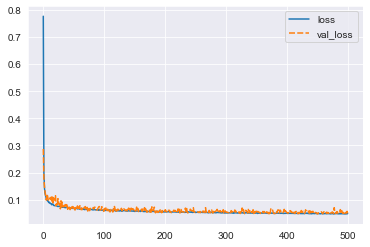

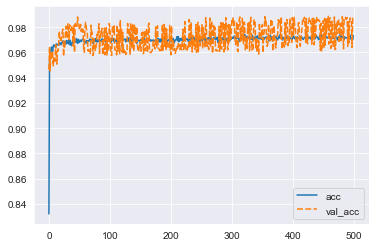

In [22]:
loss = pd.DataFrame(history.history)[['loss', 'val_loss']]
acc = pd.DataFrame(history.history)[['acc', 'val_acc']]

sns.lineplot(data=loss)
plt.show()
sns.lineplot(data=acc)
plt.show()

### Last 100 Epochs

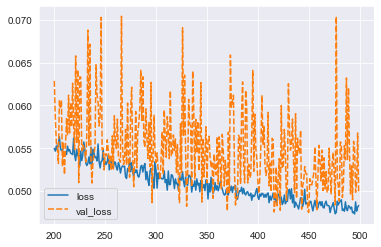

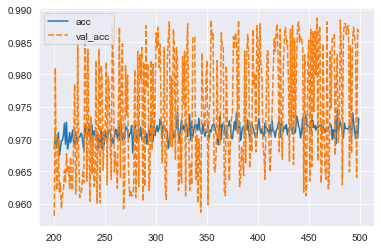

In [23]:
loss = pd.DataFrame(history.history)[['loss', 'val_loss']].iloc[200:,:]
acc = pd.DataFrame(history.history)[['acc', 'val_acc']].iloc[200:,:]

sns.lineplot(data=loss)
plt.show()
sns.lineplot(data=acc)
plt.show()

## TensorBoard

In [18]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 21084), started 3 days, 22:10:02 ago. (Use '!kill 21084' to kill it.)

> tensorboard dev upload --logdir logs --name "Pedastrian Trajectory: LSTM 5-1-500" --one_shot

### Prediction

In [19]:
y_pred = []
for val in X_test:
    pred = model.predict(val[np.newaxis])
    y_pred.append(pred)

print(tf.keras.metrics.mean_absolute_error(y_pred, y_test).numpy())

[[0.06326567 5.32068247 6.26055786 ... 4.88008283 3.69464627 2.84025062]
 [5.39642275 0.02335209 1.84712508 ... 4.30848862 2.69486607 2.97262258]
 [6.30834434 1.83270494 0.01547894 ... 5.23221562 3.63602866 3.77041548]
 ...
 [4.9443376  4.29915977 5.22382598 ... 0.05065011 1.61072752 3.00746329]
 [3.76474939 2.68115718 3.62729536 ... 1.62089763 0.01242873 1.42509171]
 [2.92464865 2.96486139 3.78399619 ... 2.9891483  1.44664273 0.02567151]]


In [30]:
model.predict(X_test[0][np.newaxis])

#### Error

In [21]:
error = tf.keras.metrics.MeanAbsoluteError()
error.update_state(y_pred, y_test)
error.result().numpy()

3.0359452